# OBJETIVO: Predecir la Calidad del Aire para el año 2020
<br> <br/>
### Contexto comercial 
En India, una industria fundamentalmente basada en la quema de carbón, los gases tóxicos generados por el sector de la construcción y los escapes de los vehículos de uso privado, así como la quema de biomasa en las zonas rurales, son los principales responsables de la degradación del aire, constituyendo un grave problema para la salud.

India se encuentra entre los 10 países más contaminados del mundo. De las 30 ciudades más contaminadas del mundo, 21 están en India. EL gobierno se comprometió a implementar medidas medioambientales para mejorar la calidad del aire 

Será muy útil predecir la calidad del aire en los próximos años para determinar cómo este problema seguirá afectando a lo largo del tiempo.
<br> <br/>
### Problema comercial
Se desea estimar el índice de calidad del aire del año 2020 para seguir evaluando su comportamiento y si va empeorando o no. Esto se realizará en función de las mediciones históricas obtenidas en diferentes ciudades de India.
<br> <br/>
### Contexto analítico 
Para poder desarrollar el modelo se cuenta con un conjunto de 29531 mediciones de diferentes ciudades de India.
<br> <br/>
Las variables disponibles (16) son en su mayoria, mediciones de diferentes contaminantes y son las siguientes: 
<br> <br/>
1. City: ciudad donde se realizó la medición
2. Date: Fecha de medición
3. PM2.5: partículas suspendidas en el aire de diametro menor a 2,5 micras
4. PM10: partículas suspendidas en el aire de diametro menor a 10 micras
5. NO: óxido de nitrogeno
6. NO2: dióxido de nitrógeno
7. NOx: óxidos de nitrógeno
8. NH3: Amoniaco
9. CO: óxido de carbono
10. SO2: dióxido de azufre
11. O3: Ozono
12. Benzene: Benceno
13. Toluene: Tolueno
14. Xilene: Xileno
15. AQI: Indice de calidad del aire
16. AQI bucket: Niveles categoricos del Indice de calidad del aire 

In [4]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('bmh')

# Libreria para estimar regresión
import statsmodels.api as sm
# Libreria para estimar regresión
import statsmodels.formula.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Para forwad selection
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# Tratamiento: usando SimpleImputer
from sklearn.impute import SimpleImputer

In [5]:
#Selección la ruta

url = 'https://raw.githubusercontent.com/Prisddt/Proyecto.Final/main/quality_air.csv'

df = pd.read_csv(url)


In [6]:
print(df.head())

        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  


In [4]:
# Crear una nueva columna 'ID' con valores únicos para cada fila
df['ID'] = range(1, len(df) + 1)

In [5]:
# Algunas estadísticas de mi variable target
variable_target = df['AQI']
variable_target.describe().round(0)

count    24850.0
mean       166.0
std        141.0
min         13.0
25%         81.0
50%        118.0
75%        208.0
max       2049.0
Name: AQI, dtype: float64

## Evaluemos valores vacíos de la Variable Target
<br>


In [6]:
# Tiene valores faltantes?
df['AQI'].isnull().value_counts()

AQI
False    24850
True      4681
Name: count, dtype: int64

In [7]:
# Eliminar filas con valores nulos en la columna 'AQI'
df = df.dropna(subset=['AQI'])

In [8]:
print("Número de valores nulos en 'AQI' después de eliminarlos:", df['AQI'].isnull().sum())

Número de valores nulos en 'AQI' después de eliminarlos: 0


In [9]:
# Calculo de los vacíos de las otras variables 
valores_nulos  = df.isnull().sum()
columnas_con_nulos = valores_nulos[valores_nulos > 0]
print('Cantidad de columnas con valores vacíos:')
print(columnas_con_nulos.shape)
print('')
print('Variables con valores vacíos: ')
print(columnas_con_nulos.sort_values(ascending=False))

Cantidad de columnas con valores vacíos:
(12,)

Variables con valores vacíos: 
Xylene     15372
PM10        7086
NH3         6536
Toluene     5826
Benzene     3535
NOx         1857
O3           807
PM2.5        678
SO2          605
CO           445
NO2          391
NO           387
dtype: int64


In [10]:
# Seleccionar las filas que tienen valores nulos en todas las variables especificadas
filas_con_nulos = df[df[['NOx', 'NO','NO2']].isnull().all(axis=1)]

# Verificar el número de filas con nulos en todas las variables
print("Número de filas con valores nulos en todas las variables: ", len(filas_con_nulos))

Número de filas con valores nulos en todas las variables:  138


In [11]:
# Eliminar filas con valores nulos en 'NOx', 'NO', y 'NO2'
df = df.dropna(subset=['NOx', 'NO', 'NO2'])

# Verificar el número de filas después de eliminar los nulos
print("Número de filas después de eliminar valores nulos en 'NOx', 'NO' y 'NO2': ", len(df))

Número de filas después de eliminar valores nulos en 'NOx', 'NO' y 'NO2':  22686


In [12]:
# Eliminar filas con valores nulos en la columna 'AQI'
df = df.dropna(subset=['PM2.5'])

In [13]:
# Calculo de los vacíos de las otras variables 
valores_nulos  = df.isnull().sum()
columnas_con_nulos = valores_nulos[valores_nulos > 0]
print('Cantidad de columnas con valores vacíos:')
print(columnas_con_nulos.shape)
print('')
print('Variables con valores vacíos: ')
print(columnas_con_nulos.sort_values(ascending=False))

Cantidad de columnas con valores vacíos:
(8,)

Variables con valores vacíos: 
Xylene     13265
PM10        6320
NH3         5544
Toluene     4526
Benzene     2445
O3           508
SO2          399
CO            77
dtype: int64


In [14]:
#Calcular el numero de filas de la data considerando la columna ID
numero_filas = df['ID'].count()

print("Número de filas no nulas en la columna 'nombre_de_la_columna':", numero_filas)

Número de filas no nulas en la columna 'nombre_de_la_columna': 22498


## Conclusión
Se eliminan 4681 filas que no tienen valores en ninguna columna de medicion de contaminantes, posiblemente los monitores de aire presentaban fallas. 
Quedaron 24850 filas con valores sin NaN de la variable AQI. 

## EDA

Text(0.5, 1.0, 'Distribución de Indice de calidad del Aire')

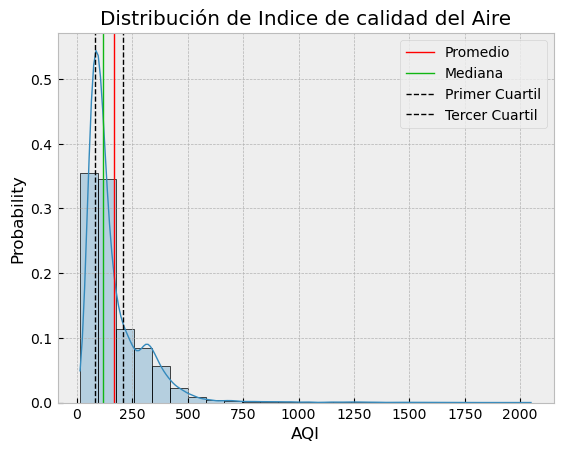

In [15]:
# Histograma variable target 
# Primero calculo algunas medidas que quiero presentar 
media = variable_target.mean()
mediana = variable_target.median()
primer_cuartil = variable_target.quantile(0.25)
tercer_cuartil = variable_target.quantile(0.75)

# Luego grafico
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'AQI',
             bins = 25,            
             alpha = 0.30,
             kde = True,
             stat='probability',
             line_kws={'color': 'black', 'linewidth': 1},# Agregar líneas negras a los bordes de las barras del histograma
            edgecolor='black')    # Agregar línea negra a las barras del histogra

# Agrego linea de promedio 
plt.axvline(x = media, 
            color = 'red', 
            linestyle = '-', 
            label = 'Promedio',
            linewidth = 1)
# Agrego linea de mediana 
plt.axvline(x = mediana, 
            color = '#11B613', 
            linestyle = '-', 
            label = 'Mediana',
            linewidth = 1)
# Agrego linea de primer cuartil 
plt.axvline(x = primer_cuartil, 
            color = 'black', 
            linestyle = '--', 
            label = 'Primer Cuartil',
            linewidth = 1)
# Agrego linea de tercer cuartil 
plt.axvline(x = tercer_cuartil, 
            color = 'black', 
            linestyle = '--', 
            label = 'Tercer Cuartil',
            linewidth = 1)

plt.legend()

plt.title('Distribución de Indice de calidad del Aire')

## Análisis Variable Target: AQI
Se visualiza que la variable tiene una distribución asimétrica positiva (la mediana es menor que el promedio), concentrando gran porción de los registros en valores bajos, y observando muy pocos registros en valores altos.  
<br> <br/>
Esto indicaría que hay muy pocas mediciones con AQI extremadamente altos. 
<br> <br/>
Al tratar con una variable target de este tipo de distribución, una buena prácica suele ser intentar predecir el logaritmo de la variable, para suavizar un poco la curva de valores posibles. 
<br> <br/>
A continuación se presentará el histograma del logaritmo de la variable target. 

Text(0.5, 1.0, 'Distribución de AQI transformado a Logaritmo')

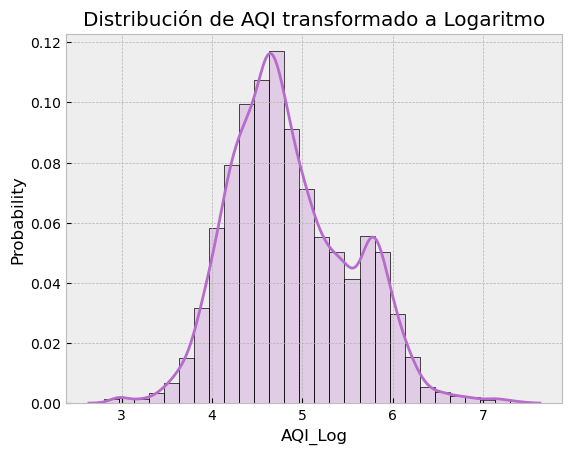

In [16]:
# Primero genero la variable logaritmica 
df['AQI_Log'] = np.log(df['AQI'])

# Luego grafico
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'AQI_Log',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
             color = '#B76BCB',
            edgecolor='black')
plt.title('Distribución de AQI transformado a Logaritmo')

## Conclusión: 
Se puede apreciar una distribución más simétrica de la variable, pero me hace ruido que tenga dos picos. Veamos la posibilidad de tratar los outliers. 

## Evaluemos valores outliers
<br>

In [17]:
# Metodo 1: IQR 
#calcular el 1er y 3er cuartil, luego sacar la diferencia para calcular intercuartilico

primer_cuartil = variable_target.quantile(0.25)
tercer_cuartil = variable_target.quantile(0.75)
rango_intercuartilico = tercer_cuartil - primer_cuartil

# calcular Limites: (1.5 será cambiado por 3.5)
limite_inf = primer_cuartil - (4 * rango_intercuartilico)
limite_sup = tercer_cuartil + (3.5 * rango_intercuartilico)

#Potencial outliers por abajo un precio que sea menor a 3937
#Potencialoutliers por arriba es un precio que sea mayor a 340037
print(limite_inf,limite_sup)
print(primer_cuartil,tercer_cuartil,rango_intercuartilico)

-427.0 652.5
81.0 208.0 127.0


In [18]:
# Identifico outliers: 
# si el precio venta es menor al limite inferior o mayor al limte superior  poner un 1, sino un cero
df['Outlier_IQR'] = np.where((df['AQI'] < limite_inf) | (df['AQI'] > limite_sup),1,0)
df['Outlier_IQR'].value_counts()

#28173 no son outlier, limites aceptables y 1358 casos son outliers

Outlier_IQR
0    22239
1      259
Name: count, dtype: int64

Text(0.5, 1.0, 'Detección Outliers - Metodo IQR')

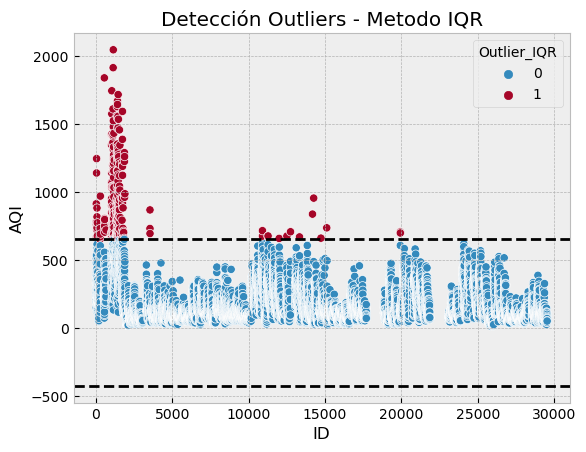

In [19]:
# Grafico, concentracion de datos azules, y los mas alejado naranjos
plt.figure()
sns.scatterplot(data = df,
                x = 'ID',
                y = 'AQI',
               hue = 'Outlier_IQR')
plt.axhline(y = limite_inf, 
            color = 'black', 
            linestyle = '--', 
            label = 'Limite Inferior',
            linewidth = 2)
plt.axhline(y = limite_sup, 
            color = 'black', 
            linestyle = '--', 
            label = 'Limite Superior',
            linewidth = 2)
plt.title('Detección Outliers - Metodo IQR')

<Axes: xlabel='AQI_Bucket', ylabel='AQI'>

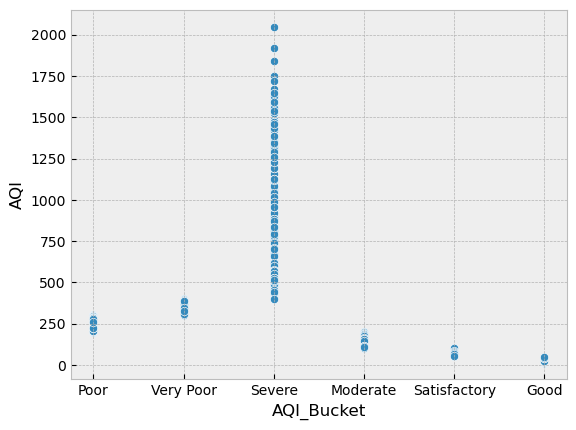

In [20]:
# Grafico de puntos
plt.figure()
sns.scatterplot(data = df,
                x = 'AQI_Bucket',
                y = 'AQI')

## Conclusión:

Al intentar evaluar los outliers con el método IQR, se visualizan puntos fuera de la concentración de datos que podría ser eliminados, pero al estudiar un poco más la data y realizar un gráfico de puntos de la variable target con la variable AQI_Bucket, se puede deducir que los datos AQI son agrupados según su nivel de riesgo, teniendo la siguiente conclusión:

Valores de Indice de calidad de Aire (AQI) entre

0 y 100 son considerados con nivel satisfactorio,
100-200 son considerados con nivel moderado,
200-300 son considerados con nivel pobre,
300-400 son considerados con nivel muy pobre,
Valores >400 son considerados nivel severo.

Al agrupar los datos según su nivel de riesgo no se visualiza  valores outliers, si no que cada medición y valor de AQI quedan dentro de una categoría. 

# Filter Feature Selection

## Correlación con el Target 

Lo próximo que analizaremos es el coeficiente de correlación entre cada variable disponible, y la variable target. 
 <br> <br/>
 Algo a tener en cuenta es que este análisis, en principio, es válido únicamente para las variables numéricas. Dado que el dataset tiene muchas variables disponibles, haremos este análisis para detectar cuáles son las variables numéricas más relacionadas con la variable target, para detenernos en el análisis de algunas de ellas. 

In [21]:
# Definir la lista de variables categóricas
variables_categoricas = ['City', 'AQI_Bucket', 'Date'] 

# Obtén las columnas numéricas
variables_numericas = df.select_dtypes(include=['number'])

In [22]:
# Calculo matriz de correlación 
matriz_correlacion = variables_numericas.corr(method='pearson')
# Selecciono a la variable target para estudiar únicamente correlación con ella 
matriz_correlacion_target = matriz_correlacion['AQI_Log']
# Calculo valor absoluto, para extraer correlaciones más fuertes independientemente de su sentido 
matriz_correlacion_target = abs(matriz_correlacion_target)
# Menciono columnas que quiero excluir del análisis de correlación 
columnas_a_excluir = ['AQI', 'AQI_Log']
# Las excluyo del análisis
matriz_correlacion_target = matriz_correlacion_target.drop(columns=columnas_a_excluir, index=columnas_a_excluir)
# Ordeno de mayor a menor correlacion 
matriz_correlacion_target = matriz_correlacion_target.sort_values(ascending=False)

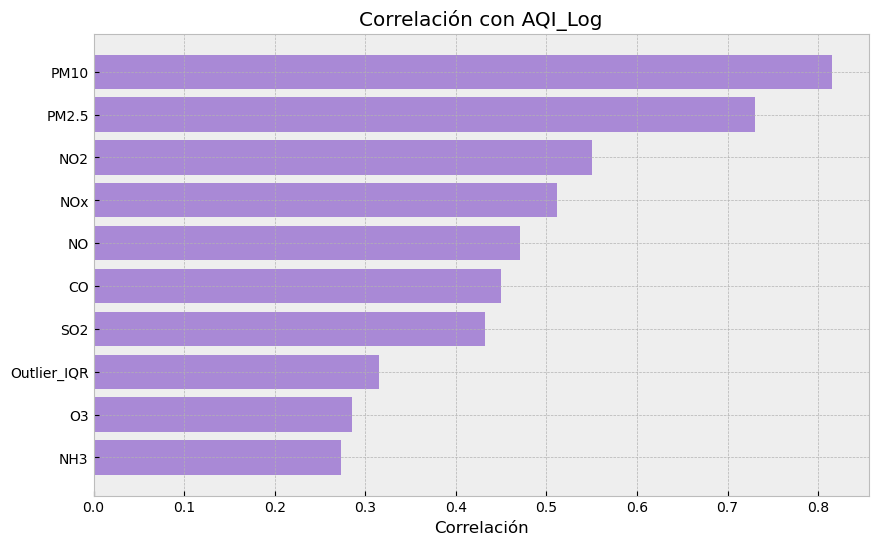

In [23]:
# Grafico el top 10 de variables más correlacionadas
matriz_correlacion_target_graficar = matriz_correlacion_target[0:10]
plt.figure(figsize=(10, 6))  # Tamaño de la figura
plt.barh(matriz_correlacion_target_graficar.index, 
         matriz_correlacion_target_graficar.values,
         color = '#A989D6')
plt.xlabel('Correlación')
plt.title('Correlación con AQI_Log')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la característica más relevante en la parte superior
plt.show()

## Conclusión: 
Se obtiene valores de correlación solo considerando variables númericas.
Las variables PM10 y PM2.5 tienen una alta correlación (mayor a 0,8) con la varible target AQI. 

# Relación de variable target con Variables que tiene mayor correlación

Text(0.5, 1.0, 'Distribución de PM10')

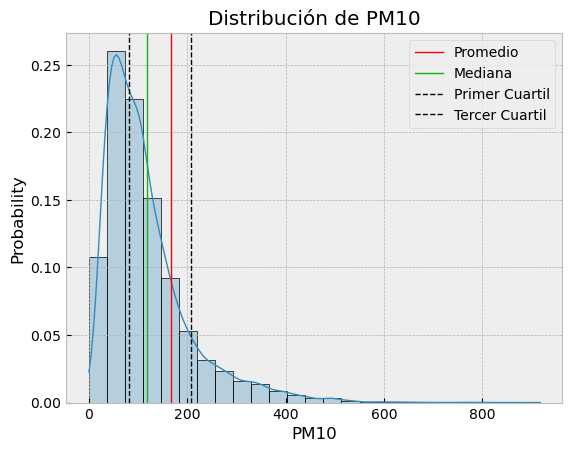

In [24]:
# Histograma variable target 
# Primero calculo algunas medidas que quiero presentar 
media = variable_target.mean()
mediana = variable_target.median()
primer_cuartil = variable_target.quantile(0.25)
tercer_cuartil = variable_target.quantile(0.75)

# Luego grafico
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'PM10',
             bins = 25,            
             alpha = 0.30,
             kde = True,
             stat='probability',
             line_kws={'color': 'black', 'linewidth': 1},# Agregar líneas negras a los bordes de las barras del histograma
            edgecolor='black')    # Agregar línea negra a las barras del histogra

# Agrego linea de promedio 
plt.axvline(x = media, 
            color = 'red', 
            linestyle = '-', 
            label = 'Promedio',
            linewidth = 1)
# Agrego linea de mediana 
plt.axvline(x = mediana, 
            color = '#11B613', 
            linestyle = '-', 
            label = 'Mediana',
            linewidth = 1)
# Agrego linea de primer cuartil 
plt.axvline(x = primer_cuartil, 
            color = 'black', 
            linestyle = '--', 
            label = 'Primer Cuartil',
            linewidth = 1)
# Agrego linea de tercer cuartil 
plt.axvline(x = tercer_cuartil, 
            color = 'black', 
            linestyle = '--', 
            label = 'Tercer Cuartil',
            linewidth = 1)

plt.legend()

plt.title('Distribución de PM10')

# Conclusión
En este histograma, la varible con mayor correlación con la variable target tiene una distribución asimétrica positiva (la mediana es menor que el promedio), concentrando gran porción de los registros en valores bajos, y observando muy pocos registros en valores altos.

Text(0.5, 1.0, 'Distribución de PM10 transformado a Logaritmo')

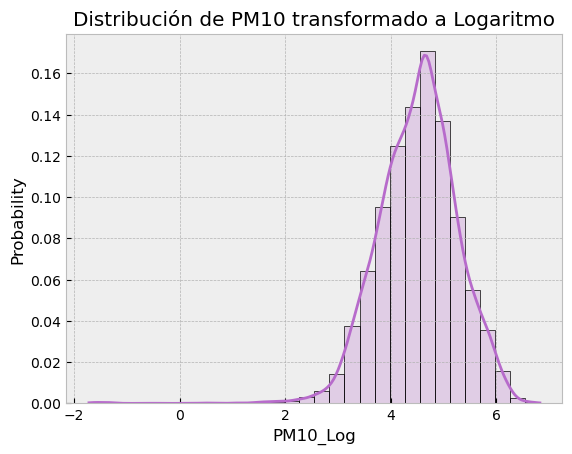

In [25]:
# genero la variable logaritmica 
df['PM10_Log'] = np.log(df['PM10'])

# Luego grafico
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'PM10_Log',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
             color = '#B76BCB',
            edgecolor='black')
plt.title('Distribución de PM10 transformado a Logaritmo')

## Conclusión: 
De esta manera, sigue quedando asimetrica pero negativa. Se seguirá usando de forma logaritmica para que sea comparativa con la variable target (AQI_Log).

Text(0.5, 1.0, 'Relación entre AQI y PM10(en logaritmo las dos)')

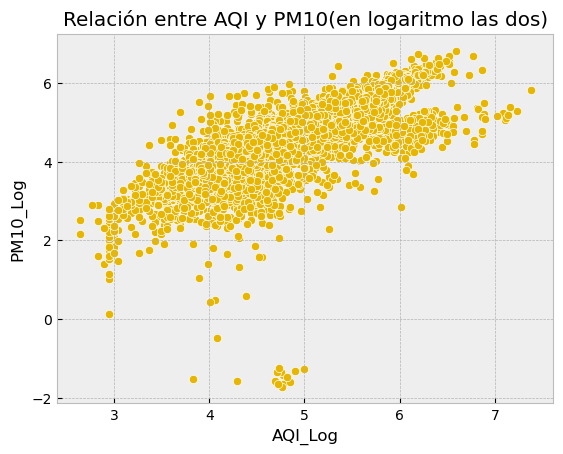

In [26]:
# Gráfico de puntos para evaluar relación
sns.scatterplot(data = df,
                x = 'AQI_Log',
                y = 'PM10_Log',
                color = '#E7B602')
plt.title('Relación entre AQI y PM10(en logaritmo las dos)')

# Conclusión
En este gráfico, se puede ver claramente la relación directamente proporcional, entre el logartimos de la variable target AQI_log y la variable con mayor correlación PM10_Log.

Text(0.5, 1.0, 'Distribución de PM2.5')

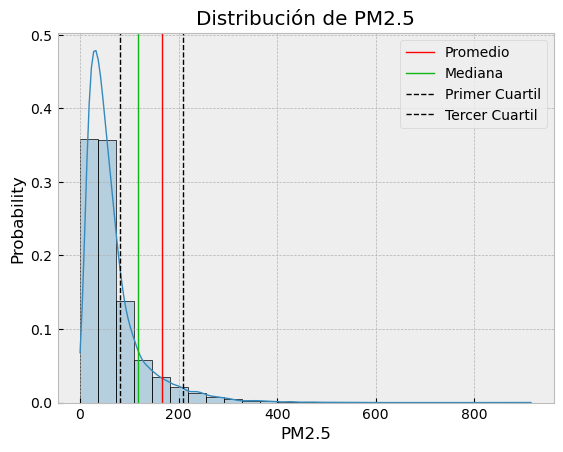

In [27]:
# Histograma variable target 
# Primero calculo algunas medidas que quiero presentar 
media = variable_target.mean()
mediana = variable_target.median()
primer_cuartil = variable_target.quantile(0.25)
tercer_cuartil = variable_target.quantile(0.75)

# Luego grafico
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'PM2.5',
             bins = 25,            
             alpha = 0.30,
             kde = True,
             stat='probability',
             line_kws={'color': 'black', 'linewidth': 1},# Agregar líneas negras a los bordes de las barras del histograma
            edgecolor='black')    # Agregar línea negra a las barras del histogra

# Agrego linea de promedio 
plt.axvline(x = media, 
            color = 'red', 
            linestyle = '-', 
            label = 'Promedio',
            linewidth = 1)
# Agrego linea de mediana 
plt.axvline(x = mediana, 
            color = '#11B613', 
            linestyle = '-', 
            label = 'Mediana',
            linewidth = 1)
# Agrego linea de primer cuartil 
plt.axvline(x = primer_cuartil, 
            color = 'black', 
            linestyle = '--', 
            label = 'Primer Cuartil',
            linewidth = 1)
# Agrego linea de tercer cuartil 
plt.axvline(x = tercer_cuartil, 
            color = 'black', 
            linestyle = '--', 
            label = 'Tercer Cuartil',
            linewidth = 1)

plt.legend()

plt.title('Distribución de PM2.5')

# Conclusión
En este histograma, la varible con mayor correlación con la variable target tiene una distribución asimétrica positiva (la mediana es menor que el promedio), concentrando gran porción de los registros en valores bajos, y observando muy pocos registros en valores altos.

Text(0.5, 1.0, 'Distribución de PM2.5 transformado a Logaritmo')

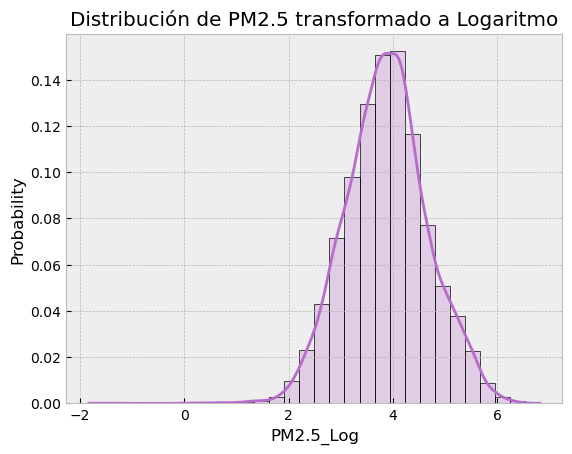

In [28]:
#genero la variable logaritmica 
df['PM2.5_Log'] = np.log(df['PM2.5'])

# Luego grafico
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'PM2.5_Log',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
             color = '#B76BCB',
            edgecolor='black')
plt.title('Distribución de PM2.5 transformado a Logaritmo')

## Conclusión: 
De esta manera, la variable PM2.5_log sigue quedando asimetrica pero negativa. Se seguirá usando de forma logaritmica para que sea comparativa con la variable target (AQI_Log).

Text(0.5, 1.0, 'Relación entre AQI y PM2.5(en logaritmo las dos)')

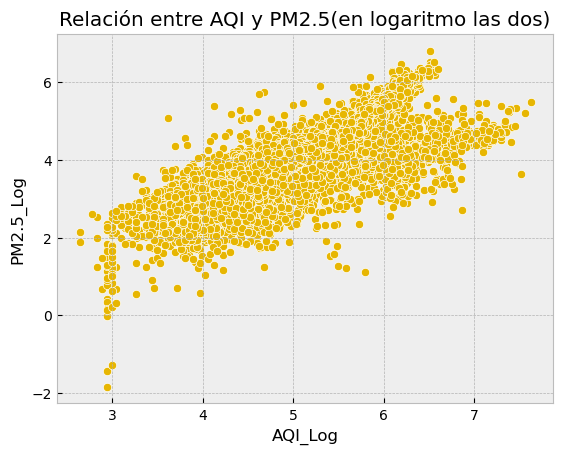

In [29]:
# Gráfico de puntos para evaluar relación
sns.scatterplot(data = df,
                x = 'AQI_Log',
                y = 'PM2.5_Log',
                color = '#E7B602')
plt.title('Relación entre AQI y PM2.5(en logaritmo las dos)')

# Conclusión
En este gráfico, se puede ver claramente la relación directamente proporcional, entre el logartimo de la variable target AQI_log y la variable con mayor correlación PM2.5_Log.

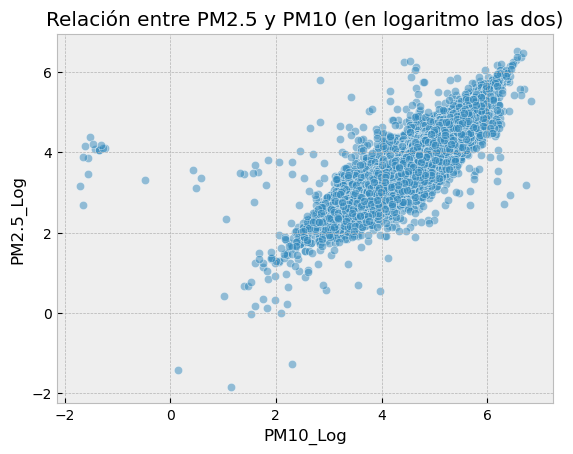

In [30]:
# Calcula el logaritmo de la columna 'PM10' y 'PM2.5'
df['PM10_Log'] = np.log(df['PM10'])
df['PM2.5_Log'] = np.log(df['PM2.5'])

# Luego, crea el gráfico de dispersión
sns.scatterplot(data=df, x='PM10_Log', y='PM2.5_Log', alpha=0.5)
plt.title('Relación entre PM2.5 y PM10 (en logaritmo las dos)')
plt.show()

# Conclusión
En este gráfico, podemos visualizar que existe alguna relacion entre las dos variables con mayor correlación a la varibale target. 

# Análisis multivariado
¿Cómo es la correlación entre las variables seleccionadas? 

In [31]:
# Definir la lista de variables categóricas
variables_categoricas = ['City', 'AQI_Bucket', 'Date'] 

# Obtén las columnas numéricas
variables_numericas = df.select_dtypes(include=['number'])

In [32]:
# Elijo el top 10 de variables más correlacionadas con el target
features_selec = matriz_correlacion_target.index[0:10]
features_selec

Index(['PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'CO', 'SO2', 'Outlier_IQR', 'O3',
       'NH3'],
      dtype='object')

<Axes: >

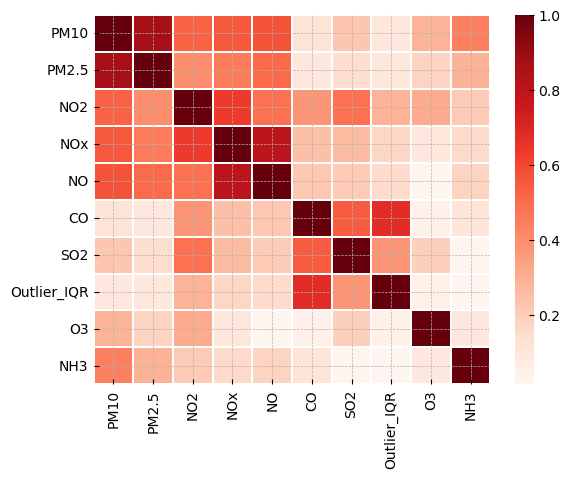

In [33]:
#calculo y grafico matriz de correlación multivariada
matriz_correlacion = df[features_selec].corr(method='pearson')
sns.heatmap(abs(matriz_correlacion),
           #cbar=False,
           linewidths = 0.3,
           cmap = 'Reds')

las variables PM10 y PM2.5 estan fuertemente relacionadas, al igual que NO y NOx

In [34]:
# Calculamos la correlación
correlaciones_absolutas = abs(variables_numericas.corr(method='pearson')['PM10'])
correlaciones_filtradas = correlaciones_absolutas[(correlaciones_absolutas < 1) & (correlaciones_absolutas > 0.35)].sort_values(ascending=False)

# Ahora puedes usar 'correlaciones_filtradas' en lugar de 'correlacion'
print(correlaciones_filtradas)

PM10_Log     0.874070
PM2.5        0.870780
AQI_Log      0.814958
PM2.5_Log    0.814267
AQI          0.801553
NO           0.572329
NOx          0.556204
NO2          0.529704
NH3          0.445895
Name: PM10, dtype: float64


In [36]:
# Ejemplo para ubicarlos, Ccuales con las variables que tienen relación la variable PM10
PM10_CORR = matriz_correlacion['PM10']
PM10_CORR[(abs(PM10_CORR)>0.5) & (PM10_CORR != 1)]

PM2.5    0.870780
NO2      0.529704
NOx      0.556204
NO       0.572329
Name: PM10, dtype: float64

## Conclusiones de análisis multivariado: 
Según la matriz y al igual que en la evaluación, los features con mayor correlación son PM10 y PM2.5 con valores mayores a 0,8. Luego lo sigue NO, NO2 y NOx con valores entre 0,53 y 0,57. 

## Tratamiento de Vacíos de otras variables 

Esta vez se trataran los vacíos de las variables con mayor correlación a mi variable target.

Se está pensando tratar los vacios por interpolación, para ello graficaremos las variables mencionada con la variable PM10 siendo la que tiene mayor indice de correlación con el target.

<Axes: xlabel='PM2.5', ylabel='PM10'>

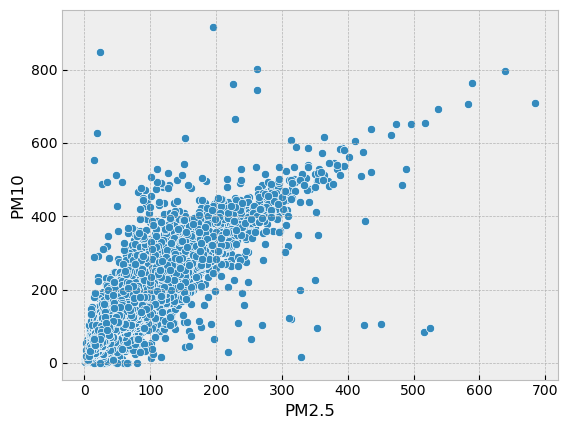

In [232]:
# Grafico de puntos
plt.figure()
sns.scatterplot(data = df,
                x = 'PM2.5',
                y = 'PM10')

<Axes: xlabel='NO2', ylabel='PM10'>

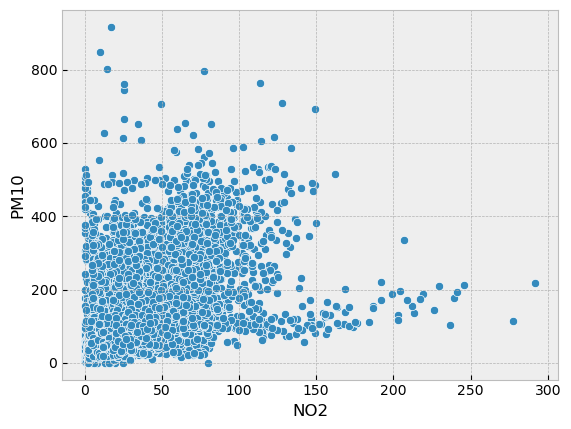

In [233]:
plt.figure()
sns.scatterplot(data = df,
                x = 'NO2',
                y = 'PM10')

<Axes: xlabel='NOx', ylabel='PM10'>

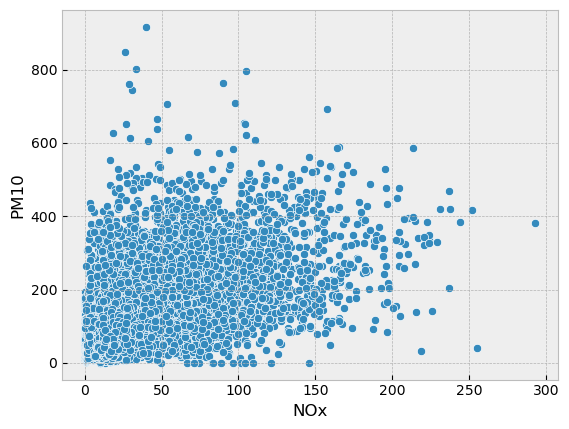

In [234]:
plt.figure()
sns.scatterplot(data = df,
                x = 'NOx',
                y = 'PM10')

<Axes: xlabel='NO', ylabel='PM10'>

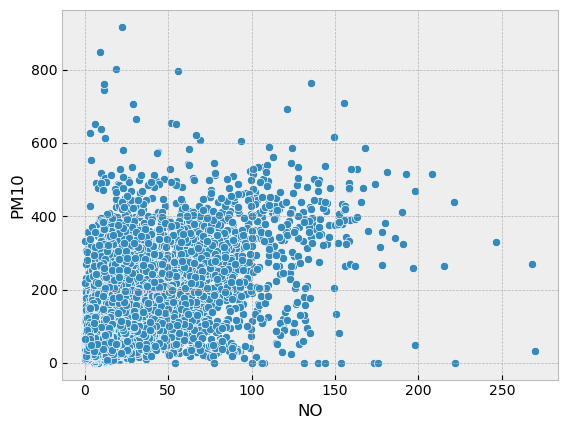

In [235]:
plt.figure()
sns.scatterplot(data = df,
                x = 'NO',
                y = 'PM10')

## Conclusión:

Podemos visualizar una relación proporcional de estas variables, por lo que se continuará con la interpolación. 

# Interporlación para Missing data

In [236]:
# Calculo de los vacíos de las otras variables 
valores_nulos  = df.isnull().sum()
columnas_con_nulos = valores_nulos[valores_nulos > 0]
print('Cantidad de columnas con valores vacíos:')
print(columnas_con_nulos.shape)
print('')
print('Variables con valores vacíos: ')
print(columnas_con_nulos.sort_values(ascending=False))

Cantidad de columnas con valores vacíos:
(9,)

Variables con valores vacíos: 
Xylene      13265
PM10         6320
PM10_Log     6320
NH3          5544
Toluene      4526
Benzene      2445
O3            508
SO2           399
CO             77
dtype: int64


### Variable a interpolar 
PM10: Se refiere a las partículas suspendidas en el aire de diametro menor a 10 micras. Siendo una variable importante para la obtención de mi variable target, es la que tiene mayor relación.  

In [237]:
# Revisar valores faltantes
df['PM10'].isnull().value_counts()

PM10
False    16178
True      6320
Name: count, dtype: int64

In [238]:
# Descripcion de la variable: 
df['PM10'].describe()

count    16178.000000
mean       117.629175
std         88.872145
min          0.180000
25%         56.420000
50%         95.255000
75%        148.667500
max        917.080000
Name: PM10, dtype: float64

## Interpolación Lineal

In [239]:
#usar metodo interpolate lineal
#cambio el nombre de las columnas para identificar con el prefijo IN_lineal
interpolar = df[['PM10','PM2.5','NOx','NO2','NO']]
df_interpolada = interpolar.interpolate(method="linear")
prefijo = "IN_lineal_"
df_interpolada = df_interpolada.add_prefix(prefijo)
df_interpolada.head()

,IN_lineal_PM10,IN_lineal_PM2.5,IN_lineal_NOx,IN_lineal_NO2,IN_lineal_NO
28,NaN,83.13,33.72,28.71,6.93
29,NaN,79.84,41.08,28.68,13.85
30,NaN,94.52,52.61,32.66,24.39
31,NaN,135.99,84.57,42.08,43.48
32,NaN,178.33,72.80,35.31,54.56


In [240]:
#Concatena la columna 'IN_lineal_PM10' del DataFrame df_interpolada y las columnas seleccionadas ('PM10', 'PM2.5', 'NO2', 'NO', 'NOx') del DataFrame original df a lo largo del eje horizontal (axis=1),
#creando así un nuevo DataFrame df_interpolada_2.
df_interpolada_2 = pd.concat([df_interpolada['IN_lineal_PM10'], interpolar], axis=1)

#Filtra las filas en las que la columna 'PM10' del DataFrame df_interpolada_2 tiene valores nulos (NaN).
df_interpolada_2[df_interpolada_2['PM10'].isnull()]


,IN_lineal_PM10,PM10,PM2.5,NOx,NO2,NO
28,NaN,NaN,83.13,33.72,28.71,6.93
29,NaN,NaN,79.84,41.08,28.68,13.85
30,NaN,NaN,94.52,52.61,32.66,24.39
31,NaN,NaN,135.99,84.57,42.08,43.48
32,NaN,NaN,178.33,72.80,35.31,54.56
...,...,...,...,...,...,...
29341,125.046667,NaN,81.26,30.37,42.48,9.55
29342,119.903333,NaN,62.22,46.34,52.05,22.95
29343,114.760000,NaN,51.79,54.01,48.39,34.78
29344,109.616667,NaN,74.53,21.25,33.50,4.21


## Interpolación Polinomial

In [241]:
interpolar = df[['PM10','PM2.5','NOx','NO2','NO']]
df_interpolada = interpolar.interpolate(method="polynomial",order = 2)
prefijo = "IN_polin_"
df_interpolada = df_interpolada.add_prefix(prefijo)
df_interpolada

,IN_polin_PM10,IN_polin_PM2.5,IN_polin_NOx,IN_polin_NO2,IN_polin_NO
28,NaN,83.13,33.72,28.71,6.93
29,NaN,79.84,41.08,28.68,13.85
30,NaN,94.52,52.61,32.66,24.39
31,NaN,135.99,84.57,42.08,43.48
32,NaN,178.33,72.80,35.31,54.56
...,...,...,...,...,...
29526,50.94,15.02,19.54,25.06,7.68
29527,74.09,24.38,16.53,26.06,3.42
29528,65.73,22.91,18.33,29.53,3.45
29529,49.97,16.64,18.80,29.26,4.05


In [242]:
df_interpolada_3 = pd.concat([df_interpolada['IN_polin_PM10'], interpolar], axis=1)
df_interpolada_3[df_interpolada_3['PM10'].isnull()]

,IN_polin_PM10,PM10,PM2.5,NOx,NO2,NO
28,NaN,NaN,83.13,33.72,28.71,6.93
29,NaN,NaN,79.84,41.08,28.68,13.85
30,NaN,NaN,94.52,52.61,32.66,24.39
31,NaN,NaN,135.99,84.57,42.08,43.48
32,NaN,NaN,178.33,72.80,35.31,54.56
...,...,...,...,...,...,...
29341,167.824814,NaN,81.26,30.37,42.48,9.55
29342,144.289804,NaN,62.22,46.34,52.05,22.95
29343,119.009610,NaN,51.79,54.01,48.39,34.78
29344,101.873533,NaN,74.53,21.25,33.50,4.21


## Interpolación nearest

In [243]:
interpolar = df[['PM10','PM2.5','NOx','NO2','NO']]
df_interpolada = interpolar.interpolate(method="nearest")
prefijo = "IN_nearest_"
df_interpolada = df_interpolada.add_prefix(prefijo)
df_interpolada

,IN_nearest_PM10,IN_nearest_PM2.5,IN_nearest_NOx,IN_nearest_NO2,IN_nearest_NO
28,NaN,83.13,33.72,28.71,6.93
29,NaN,79.84,41.08,28.68,13.85
30,NaN,94.52,52.61,32.66,24.39
31,NaN,135.99,84.57,42.08,43.48
32,NaN,178.33,72.80,35.31,54.56
...,...,...,...,...,...
29526,50.94,15.02,19.54,25.06,7.68
29527,74.09,24.38,16.53,26.06,3.42
29528,65.73,22.91,18.33,29.53,3.45
29529,49.97,16.64,18.80,29.26,4.05


In [244]:
df_interpolada_4 = pd.concat([df_interpolada['IN_nearest_PM10'], interpolar], axis=1)
df_interpolada_4[df_interpolada_4['PM10'].isnull()]

,IN_nearest_PM10,PM10,PM2.5,NOx,NO2,NO
28,NaN,NaN,83.13,33.72,28.71,6.93
29,NaN,NaN,79.84,41.08,28.68,13.85
30,NaN,NaN,94.52,52.61,32.66,24.39
31,NaN,NaN,135.99,84.57,42.08,43.48
32,NaN,NaN,178.33,72.80,35.31,54.56
...,...,...,...,...,...,...
29341,145.62,NaN,81.26,30.37,42.48,9.55
29342,145.62,NaN,62.22,46.34,52.05,22.95
29343,99.33,NaN,51.79,54.01,48.39,34.78
29344,99.33,NaN,74.53,21.25,33.50,4.21


In [245]:
# Junto toda la interpolacion
#predicción del valor faltante con cada uno de los métodos
#tambien se genera una variable que identifica a los puntos vacios 
df['IN_lineal_PM10'] = df_interpolada_2['IN_lineal_PM10']
df['IN_polin_PM10'] = df_interpolada_3['IN_polin_PM10']
df['IN_nearest_PM10'] = df_interpolada_4['IN_nearest_PM10']

# marcar con la variable 'PM10' a los que aparecen vacio
df['PM10_Vacio'] = df['PM10'].isnull()

Text(0.5, 1.0, 'Missing Values - Interpolación Lineal')

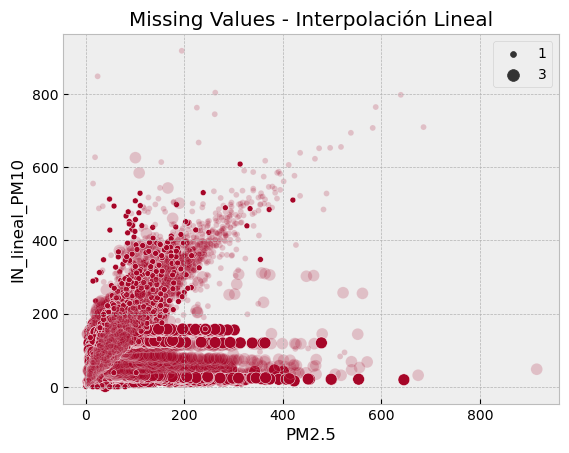

In [246]:
# Visualizo primera propuesta lineal.
valores_alpha = np.where(df['PM10_Vacio'] == True,1,0.2)
valores_tamanio = np.where(df['PM10_Vacio'] == True,3,1)
plt.figure()
sns.scatterplot(data = df,
                x = 'PM2.5',
                y = 'IN_lineal_PM10',
                alpha = valores_alpha,
                size = valores_tamanio)
plt.title('Missing Values - Interpolación Lineal')

Text(0.5, 1.0, 'Missing Values - Interpolación Lineal')

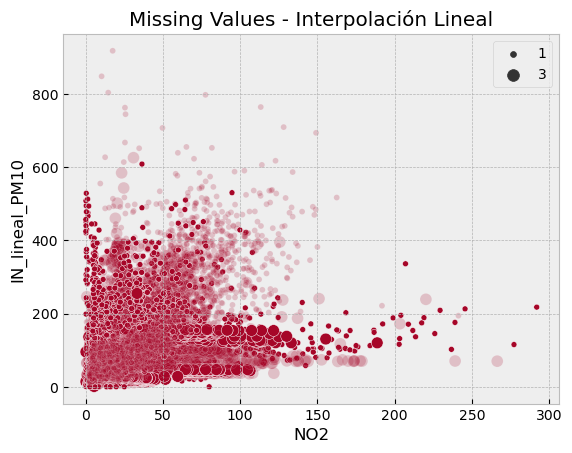

In [247]:
# Visualizo primera propuesta 
valores_alpha = np.where(df['PM10_Vacio'] == True,1,0.2)
valores_tamanio = np.where(df['PM10_Vacio'] == True,3,1)
plt.figure()
sns.scatterplot(data = df,
                x = 'NO2',
                y = 'IN_lineal_PM10',
                alpha = valores_alpha,
                size = valores_tamanio)
plt.title('Missing Values - Interpolación Lineal')

Text(0.5, 1.0, 'Missing Values - Interpolación Lineal')

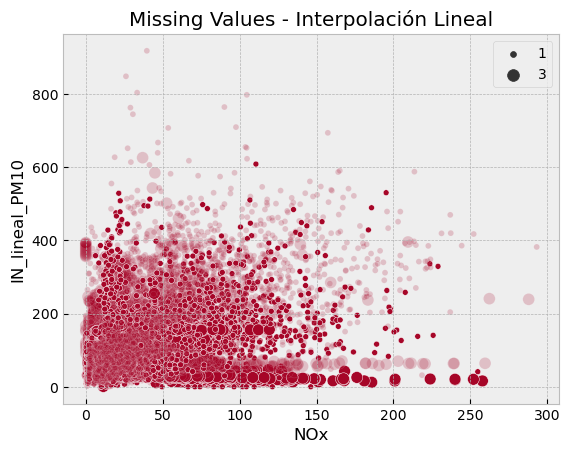

In [248]:
# Visualizo primera propuesta 
valores_alpha = np.where(df['PM10_Vacio'] == True,1,0.2)
valores_tamanio = np.where(df['PM10_Vacio'] == True,3,1)
plt.figure()
sns.scatterplot(data = df,
                x = 'NOx',
                y = 'IN_lineal_PM10',
                alpha = valores_alpha,
                size = valores_tamanio)
plt.title('Missing Values - Interpolación Lineal')

Text(0.5, 1.0, 'Missing Values - Interpolación Polinomial')

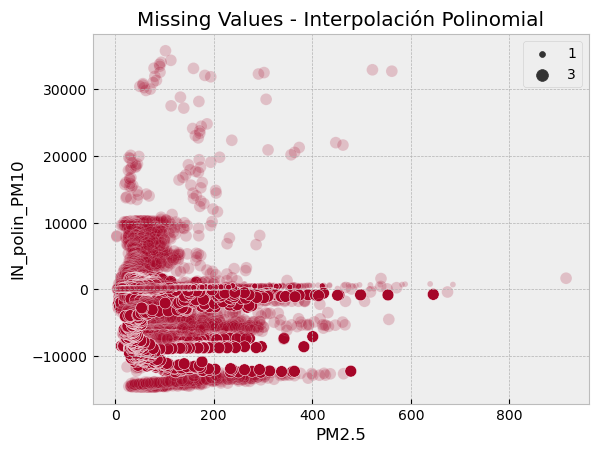

In [249]:
# Visualizo segunda propuesta polinomial
valores_alpha = np.where(df['PM10_Vacio'] == True,1,0.2)
valores_tamanio = np.where(df['PM10_Vacio'] == True,3,1)
plt.figure()
sns.scatterplot(data = df,
                x = 'PM2.5',
                y = 'IN_polin_PM10',
                alpha = valores_alpha,
                size = valores_tamanio)
plt.title('Missing Values - Interpolación Polinomial')

Text(0.5, 1.0, 'Missing Values - Interpolación Polinomial')

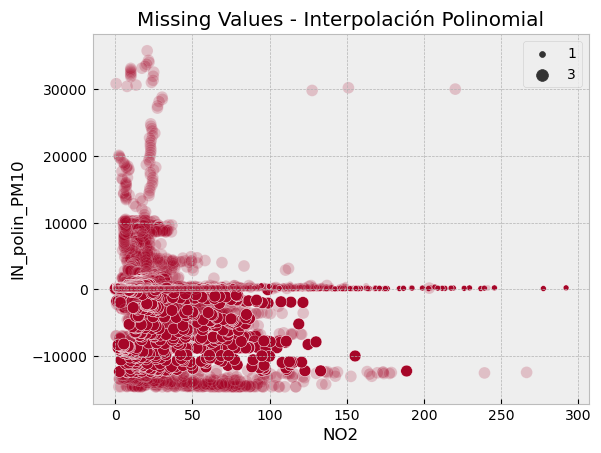

In [250]:
# Visualizo primera propuesta 
valores_alpha = np.where(df['PM10_Vacio'] == True,1,0.2)
valores_tamanio = np.where(df['PM10_Vacio'] == True,3,1)
plt.figure()
sns.scatterplot(data = df,
                x = 'NO2',
                y = 'IN_polin_PM10',
                alpha = valores_alpha,
                size = valores_tamanio)
plt.title('Missing Values - Interpolación Polinomial')

Text(0.5, 1.0, 'Missing Values - Interpolación Polinomial')

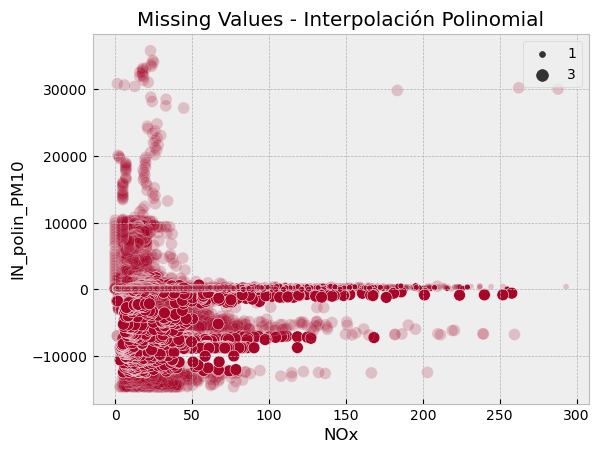

In [251]:
# Visualizo segunda propuesta polinomial
valores_alpha = np.where(df['PM10_Vacio'] == True,1,0.2)
valores_tamanio = np.where(df['PM10_Vacio'] == True,3,1)
plt.figure()
sns.scatterplot(data = df,
                x = 'NOx',
                y = 'IN_polin_PM10',
                alpha = valores_alpha,
                size = valores_tamanio)
plt.title('Missing Values - Interpolación Polinomial')

Text(0.5, 1.0, 'Missing Values - Interpolación más Cercano')

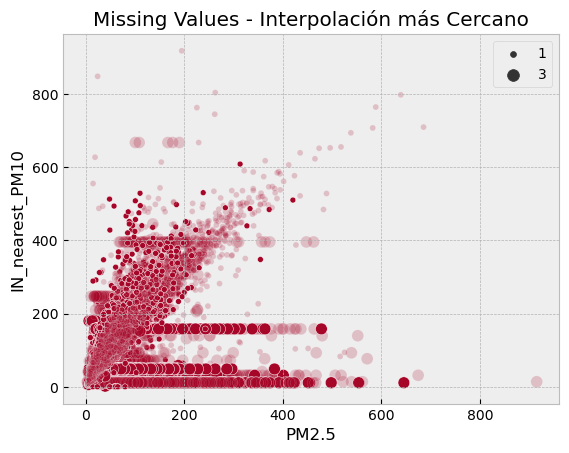

In [252]:
# Visualizo tercera propuesta Nearest
valores_alpha = np.where(df['PM10_Vacio'] == True,1,0.2)
valores_tamanio = np.where(df['PM10_Vacio'] == True,3,1)
plt.figure()
sns.scatterplot(data = df,
                x = 'PM2.5',
                y = 'IN_nearest_PM10',
                alpha = valores_alpha,
                size = valores_tamanio)
plt.title('Missing Values - Interpolación más Cercano')

Text(0.5, 1.0, 'Missing Values - Interpolación más cercano')

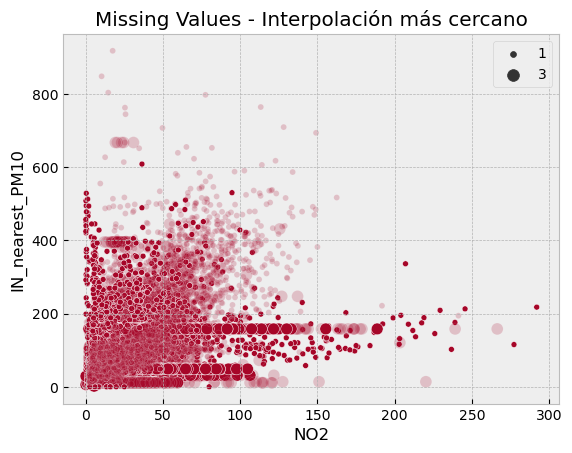

In [253]:
# Visualizo primera propuesta 
valores_alpha = np.where(df['PM10_Vacio'] == True,1,0.2)
valores_tamanio = np.where(df['PM10_Vacio'] == True,3,1)
plt.figure()
sns.scatterplot(data = df,
                x = 'NO2',
                y = 'IN_nearest_PM10',
                alpha = valores_alpha,
                size = valores_tamanio)
plt.title('Missing Values - Interpolación más cercano')

Text(0.5, 1.0, 'Missing Values - Interpolación más cercano')

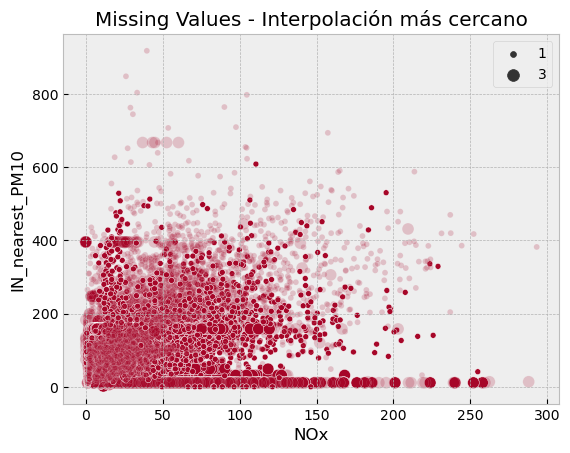

In [254]:
# Visualizo primera propuesta 
valores_alpha = np.where(df['PM10_Vacio'] == True,1,0.2)
valores_tamanio = np.where(df['PM10_Vacio'] == True,3,1)
plt.figure()
sns.scatterplot(data = df,
                x = 'NOx',
                y = 'IN_nearest_PM10',
                alpha = valores_alpha,
                size = valores_tamanio)
plt.title('Missing Values - Interpolación más cercano')

In [255]:
# Tiene valores faltantes?
df['IN_lineal_PM10'].isnull().value_counts()

IN_lineal_PM10
False    21573
True       925
Name: count, dtype: int64

In [256]:
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,AQI_Bucket,ID,AQI_Log,Outlier_IQR,PM10_Log,PM2.5_Log,IN_lineal_PM10,IN_polin_PM10,IN_nearest_PM10,PM10_Vacio
28,Ahmedabad,2015-01-29,83.13,NaN,6.93,28.71,33.72,NaN,6.93,49.52,...,Poor,29,5.342334,0,NaN,4.420406,NaN,NaN,NaN,True
29,Ahmedabad,2015-01-30,79.84,NaN,13.85,28.68,41.08,NaN,13.85,48.49,...,Very Poor,30,5.793014,0,NaN,4.380025,NaN,NaN,NaN,True
30,Ahmedabad,2015-01-31,94.52,NaN,24.39,32.66,52.61,NaN,24.39,67.39,...,Severe,31,6.242223,0,NaN,4.548811,NaN,NaN,NaN,True
31,Ahmedabad,2015-02-01,135.99,NaN,43.48,42.08,84.57,NaN,43.48,75.23,...,Severe,32,6.661855,1,NaN,4.912581,NaN,NaN,NaN,True
32,Ahmedabad,2015-02-02,178.33,NaN,54.56,35.31,72.80,NaN,54.56,55.04,...,Severe,33,6.817831,1,NaN,5.183636,NaN,NaN,NaN,True


In [257]:
# Eliminar filas con NaN en la columna 'IN_lineal_PM10'
df = df.dropna(subset=['IN_lineal_PM10'])

# Verificar si hay valores faltantes después de eliminar las filas con NaN en 'IN_lineal_PM10'
print(df['IN_lineal_PM10'].isnull().value_counts())

IN_lineal_PM10
False    21573
Name: count, dtype: int64


In [261]:
df = df.rename(columns={'IN_lineal_PM10': 'PM10_Com'})

In [262]:
df = df.rename(columns={'PM2.5': 'PM2_5'})

In [263]:
columnas = ['PM2_5', 'PM10_Com']
valores_faltantes = df[columnas].isnull().sum()
print(valores_faltantes)

PM2_5       0
PM10_Com    0
dtype: int64


## Conclusión

De acuerdo a los métodos evaluados, se elimina el polinomial por tener valores negativos.
Se opta por usar el método lineal para interpolar datos. 
Aún sigue quedando valores nulos en la variable PM10, de 6320 bajó a 925. Se decide eliminar estas 925 debido a que ya se hizo pruebas reemplazando con la media y mediana, y se obtienen buenos resultados.

# Regresion Lineal.
## Técnicas de selección de variables

## 1. Modelo de una sola variable

###  Ajuste del primer modelo de regresión lineal

**Objetivo:** 
Predecir el Indice de calidad de aire del año 2022. 

**Variable dependiente:** 
AQI

**Variable independiente:**
PM10

Text(0.5, 1.0, 'Relación entre PM10 y AQI')

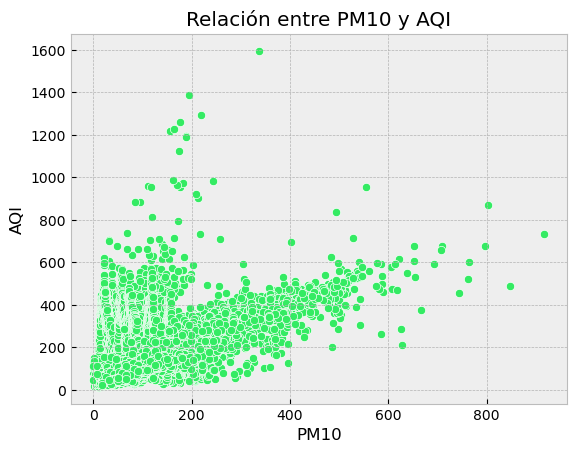

In [264]:
# Visualmente gráfico de punto de la relación entre mi variable dependiente con la variable independiente: 
plt.figure()
sns.scatterplot(data = df,
                x = 'PM10_Com',
                y = 'AQI',
               color = '#34EB63')
plt.xlabel('PM10')
plt.ylabel('AQI')
plt.title('Relación entre PM10 y AQI')

En el gráfico se puede observar una cierta relación positiva entre la variable dependiente y la independiente ya que, aparentemente, a mayor PM10, mayor es AQI.

In [265]:
# Estimo coeficientes para modelo de regresión lineal con una sola variable:
#se hace un string, con esta forma. predecir el AQI, lado derecho que es con esa variable,calcular el PM10.
model1 = 'AQI ~ PM10'

#hacer la regresion lineal con ols y el metodo fit es para ajustar los parametros
lm1   = sm.ols(formula = model1, data = df).fit()

#summary, es para mostrar la tabla de abajo
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                 2.907e+04
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:53:18   Log-Likelihood:                -89985.
No. Observations:               16178   AIC:                         1.800e+05
Df Residuals:                   16176   BIC:                         1.800e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.5774      0.822     35.991      0.0

## conclusión
tenemos un R cuadrado de 0.642.
P value es cero, siendo un buen resultado.
Intervalo de confianza son del mismo signo, es decir, no pasará por cero.


Text(0.5, 1.0, 'Datos reales vs Estimación')

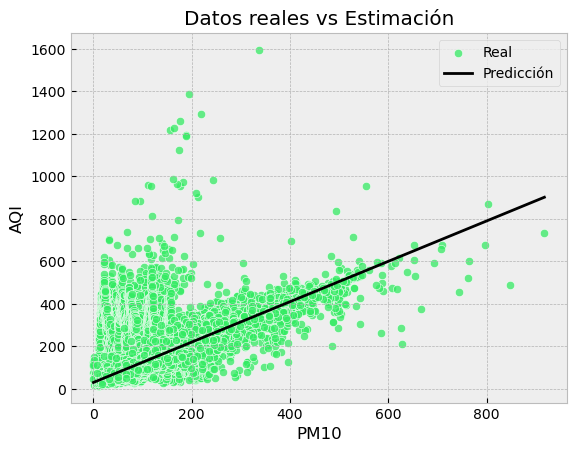

In [266]:
# Graficamente:
df['y_estimado'] = lm1.predict(df)
g1 = plt.figure()
sns.scatterplot(data = df,
                x = 'PM10_Com',
                y = 'AQI',                
                label = 'Real', 
                color = '#34EB63',
                alpha = 0.75)
sns.lineplot(data = df, 
                x = 'PM10', 
                y = 'y_estimado', 
                label = 'Predicción', 
                color = 'black')
plt.xlabel('PM10')
plt.ylabel('AQI')
plt.title('Datos reales vs Estimación')

In [267]:
#elemento params son los coeficientes
coeficientes = lm1.params
print('Coeficientes:')
print(coeficientes)


Coeficientes:
Intercept    29.577448
PM10          0.950408
dtype: float64


Estimación del AQI = 30,7065 + 0,9292 * PM10

In [268]:
#intervalo de confianza, son positivos en este caso
intervalo_confianza = lm1.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                   0          1
Intercept  27.966643  31.188252
PM10        0.939481   0.961334


Pendiente: Los dos limites de confianza toman valores positivos, por lo que es alta la posibilidad que no tome valor cero.

In [269]:
#p value, cercano a cero en este casi
pvalores = lm1.pvalues
print('P-Valores:')
print(pvalores.round(6))

P-Valores:
Intercept    0.0
PM10         0.0
dtype: float64


In [270]:
#calcula el r2
r_cuadrado = lm1.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.642


# 2. Modelo con cuatro variables

Variables : PM10, PM2.5, NOx, NO2, NO

Text(0.5, 1.0, 'Relación entre PM10 y AQI')

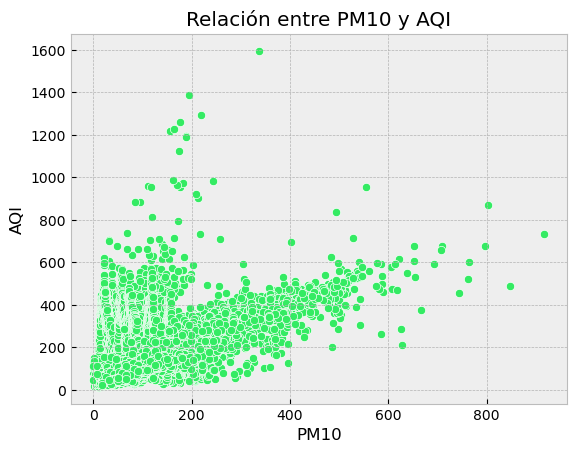

In [367]:
# Visualmente: 
plt.figure()
sns.scatterplot(data = df,
                x = 'PM10_Com',
                y = 'AQI',
               color = '#34EB63')
plt.xlabel('PM10')
plt.ylabel('AQI')
plt.title('Relación entre PM10 y AQI')

Text(0.5, 1.0, 'Relación entre PM2.5 y AQI')

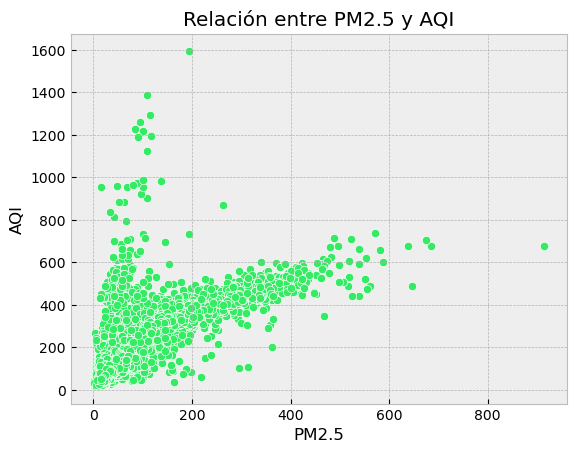

In [271]:
# Visualmente: 
plt.figure()
sns.scatterplot(data = df,
                x = 'PM2_5',
                y = 'AQI',
               color = '#34EB63')
plt.xlabel('PM2.5')
plt.ylabel('AQI')
plt.title('Relación entre PM2.5 y AQI')

Text(0.5, 1.0, 'Relación entre NOx y AQI')

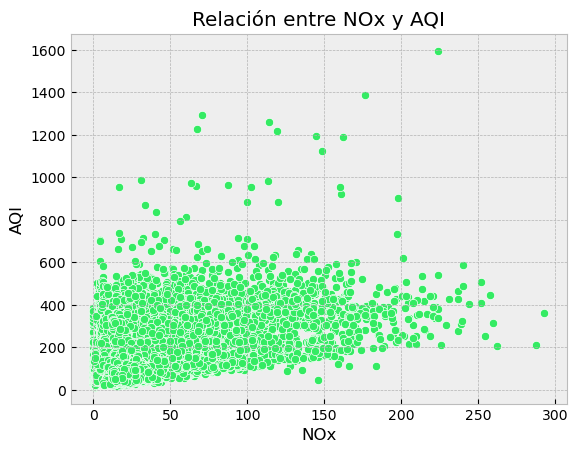

In [272]:
# Visualmente: 
plt.figure()
sns.scatterplot(data = df,
                x = 'NOx',
                y = 'AQI',
               color = '#34EB63')
plt.xlabel('NOx')
plt.ylabel('AQI')
plt.title('Relación entre NOx y AQI')

Text(0.5, 1.0, 'Relación entre NO2 y AQI')

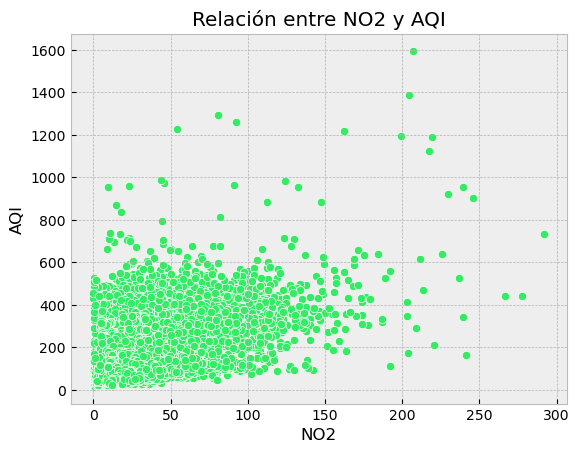

In [273]:
# Visualmente: 
plt.figure()
sns.scatterplot(data = df,
                x = 'NO2',
                y = 'AQI',
               color = '#34EB63')
plt.xlabel('NO2')
plt.ylabel('AQI')
plt.title('Relación entre NO2 y AQI')

Text(0.5, 1.0, 'Relación entre NO y AQI')

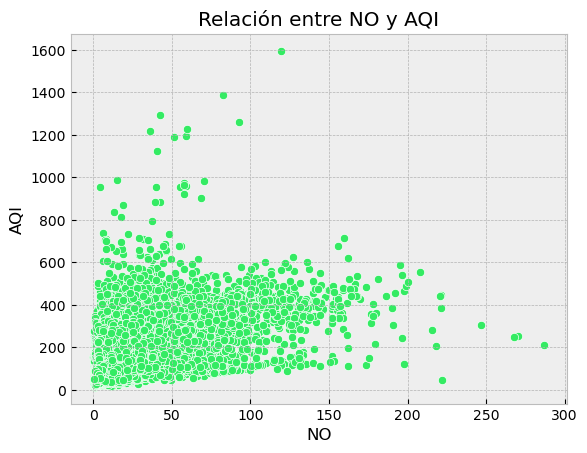

In [274]:
# Visualmente: 
plt.figure()
sns.scatterplot(data = df,
                x = 'NO',
                y = 'AQI',
               color = '#34EB63')
plt.xlabel('NO')
plt.ylabel('AQI')
plt.title('Relación entre NO y AQI')

## Conclusión: 
En ambos gráficos de dispersión, se visualiza una cierta tendencia que los graficos van hacia arriba.

In [427]:
# Estimo coeficientes para modelo de regresión lineal con una sola variable:
model2 = 'AQI ~ PM10_Com + PM2_5 + NOx + NO2 + NO'
lm2   = sm.ols(formula = model2, data = df).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 1.194e+04
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:37:40   Log-Likelihood:            -1.1762e+05
No. Observations:               21573   AIC:                         2.353e+05
Df Residuals:                   21567   BIC:                         2.353e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.0344      0.705     39.740      0.0

 El R cuadrado subió de 0,642 a 0,735.

In [428]:
coeficientes = lm2.params
print('Coeficientes:')
print(coeficientes)

Coeficientes:
Intercept    28.034362
PM10_Com      0.183455
PM2_5         1.193991
NOx           0.289137
NO2           0.736880
NO           -0.223572
dtype: float64


In [429]:
#calculo de intervalo de confianza
intervalo_confianza = lm2.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                   0          1
Intercept  26.651622  29.417101
PM10_Com    0.172176   0.194734
PM2_5       1.178467   1.209515
NOx         0.242236   0.336038
NO2         0.693705   0.780056
NO         -0.282305  -0.164838


Los intervalos de confianza son del mismo signo, es decir, no hay peligro que beta tome valor cero.

In [430]:
pvalores = lm2.pvalues
print('P-Valores:')
print(pvalores.round(6))

P-Valores:
Intercept    0.0
PM10_Com     0.0
PM2_5        0.0
NOx          0.0
NO2          0.0
NO           0.0
dtype: float64


P value, es cero es decir la variable es más confiable

In [431]:
r_cuadrado = lm2.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.735


## Conclusión

En el segundo modelo, al incluir tres variables más, se ve una mejora con el primer modelo que tiene una sola variable. 
de R2: 0,642 subió a 0,733

# Modelando con PCA

Variabilidad de las variables que quiero juntar.

In [433]:
# Selecciono variables a juntar
df_PCA = df[['PM10_Com', 'PM2_5','NOx']]
df_PCA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21573 entries, 1595 to 29530
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PM10_Com  21573 non-null  float64
 1   PM2_5     21573 non-null  float64
 2   NOx       21573 non-null  float64
dtypes: float64(3)
memory usage: 674.2 KB


In [434]:
# Extraer la matriz de características
X = df_PCA.values

In [435]:
# Crear un objeto PCA, cantidad de componentes que quiero que calcule, en este caso 2, dos variables.
pca = PCA(n_components = 2)

In [436]:
# Ajustar el modelo PCA a los datos
pca.fit(X)

PCA(n_components=2)

In [437]:
# Obtener las componentes principales
componentes_principales = pca.transform(X)

In [438]:
# Crear un nuevo DataFrame con las componentes principales
df_PCA_final = pd.DataFrame(data = componentes_principales)
df_PCA_final.head()

,0,1
0,4.589201,-29.905892
1,-2.926667,-30.138560
2,10.051058,-35.609656
3,15.194886,-41.561617
4,-4.369091,-26.792583


In [439]:
## Normalizar

In [446]:
# Selecciono variables a juntar
df_PCA = df[['PM10_Com','PM2_5','NOx']]

# Normalizo la variable (significa llevarla a una distribucion normal estandar)
scaler = StandardScaler()
X = df_PCA.values
X = scaler.fit_transform(X)

# Genero objeto pca
pca = PCA(n_components = 2)

# Se lo aplico al dataset elegido
pca.fit(X)

# Calculo PCA
componentes_principales = pca.transform(X)

# Almaceno en dataframe y presento
df_PCA_final_2 = pd.DataFrame(data = componentes_principales)
prefijo = "PC_"
df_PCA_final_2 = df_PCA_final_2.add_prefix(prefijo)
df_PCA_final_2.head()

,PC_0,PC_1
0,0.333258,0.879858
1,0.199657,0.846629
2,0.361783,0.859571
3,0.286144,0.663376
4,0.424173,1.245786


Text(0.5, 1.0, 'Gráfico de Dispersión de las Dos Primeras Componentes Principales')

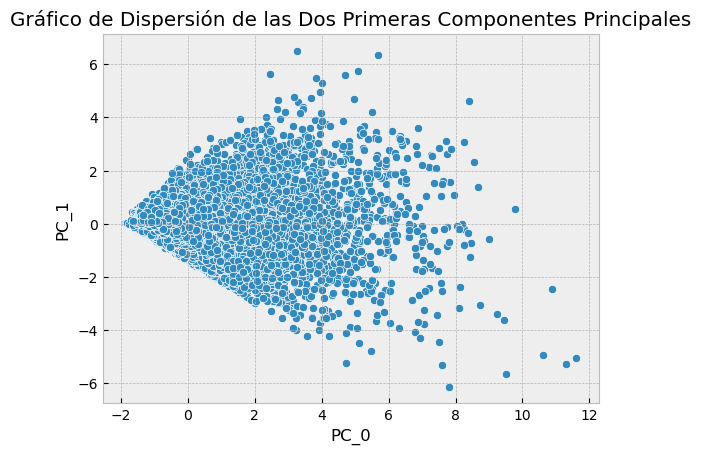

In [447]:
# Grafico de dispersión
plt.figure()
sns.scatterplot(data = df_PCA_final_2,
                x = 'PC_0',
                y = 'PC_1')
plt.title('Gráfico de Dispersión de las Dos Primeras Componentes Principales')

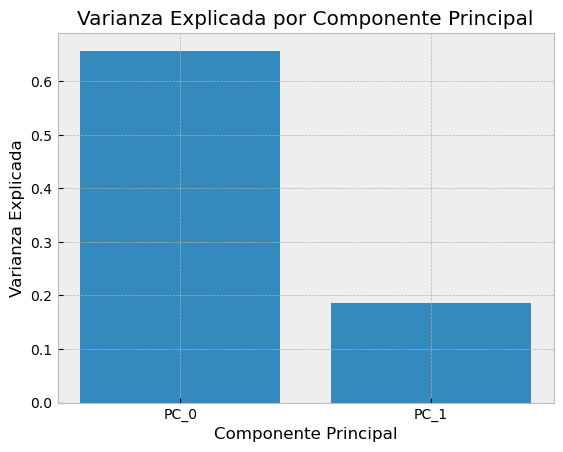

In [448]:
# Visualizar la varianza explicada por cada componente principal en un gráfico de barras
varianza_explicada = pca.explained_variance_ratio_
componentes = df_PCA_final_2.columns

plt.bar(componentes, 
        varianza_explicada)
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente Principal')
plt.show()

Text(0.5, 1.0, 'Relación entre componentes y variable target')

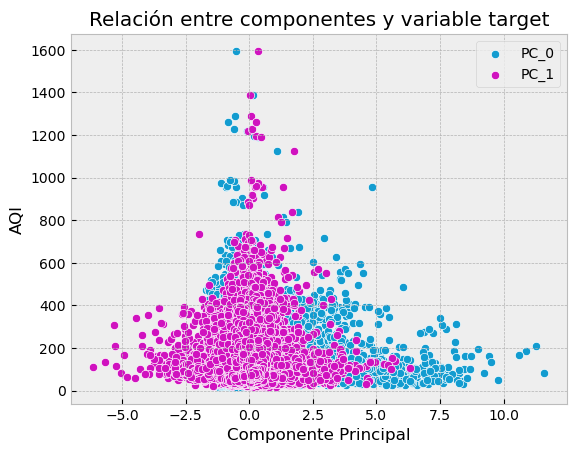

In [449]:
# Visualmente 
df['PC_0'] = df_PCA_final_2['PC_0']
df['PC_1'] = df_PCA_final_2['PC_1']

plt.figure()
sns.scatterplot(data = df,
                x = 'PC_0',
                y = 'AQI',
               label='PC_0', 
               color = '#129CD0',
                alpha = 1)
sns.scatterplot(data = df, 
                x = 'PC_1', 
                y = 'AQI', 
                label = 'PC_1', 
                color = '#D012BF',
                alpha = 1)
plt.xlabel('Componente Principal')
plt.ylabel('AQI')
plt.title('Relación entre componentes y variable target')

In [450]:
# Estimo coeficientes para modelo de regresión lineal con una sola variable origen de PCA:
model3 = 'AQI ~ PC_0'
lm3   = sm.ols(formula = model3, data = df).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     52.09
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           5.53e-13
Time:                        23:39:23   Log-Likelihood:                -98783.
No. Observations:               16120   AIC:                         1.976e+05
Df Residuals:                   16118   BIC:                         1.976e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    154.3377      0.874    176.608      0.0

In [451]:
# Estimo coeficientes para modelo de regresión lineal con una sola variable origen de PCA:
model3 = 'AQI ~ PC_1'
lm3   = sm.ols(formula = model3, data = df).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     19.77
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           8.79e-06
Time:                        23:39:24   Log-Likelihood:                -98799.
No. Observations:               16120   AIC:                         1.976e+05
Df Residuals:                   16118   BIC:                         1.976e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    154.3918      0.875    176.456      0.0

## Conclusión 
Ninguno de los dos componentes muestra relación con el target, no son buenos predictores, a la vez no se relaciona con el modelo de varias variables por separadas.
Se probó con 3 variables y con 5 variables (Incluyendo 'NO' y 'NO2') y se obtiene resultados similares, R2 cercano a cero.
 